# Week 1 Seminar

A/B experiment analysis

In [61]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [62]:
experiment = "NEW_NN"

In [63]:
data = pd.read_json("/home/bgainitdinov/MADE_lectures/2_semester/RecSys/uploaded_data/log/data.json", lines=True)
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [64]:
data#.head(15)

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2023-04-12 13:29:17.621,3255,2659,1.00,1.088e-02,4186.0,{'NEW_NN': 'C'},C
1,next,2023-04-12 13:29:17.634,3255,4186,1.00,1.929e-03,443.0,{'NEW_NN': 'C'},C
2,next,2023-04-12 13:29:17.644,3255,443,1.00,1.169e-03,308.0,{'NEW_NN': 'C'},C
3,next,2023-04-12 13:29:17.653,3255,308,0.02,1.078e-03,17079.0,{'NEW_NN': 'C'},C
4,next,2023-04-12 13:29:17.661,3255,17079,0.05,9.904e-04,11836.0,{'NEW_NN': 'C'},C
...,...,...,...,...,...,...,...,...,...
21368,next,2023-04-12 13:31:46.613,6236,711,0.82,5.698e-04,20500.0,{'NEW_NN': 'C'},C
21369,next,2023-04-12 13:31:46.618,6236,20500,0.01,5.562e-04,7018.0,{'NEW_NN': 'C'},C
21370,next,2023-04-12 13:31:46.623,6236,7018,0.65,6.506e-04,407.0,{'NEW_NN': 'C'},C
21371,next,2023-04-12 13:31:46.627,6236,407,0.00,5.498e-04,178.0,{'NEW_NN': 'C'},C


## Visualize sessions

In [65]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [66]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

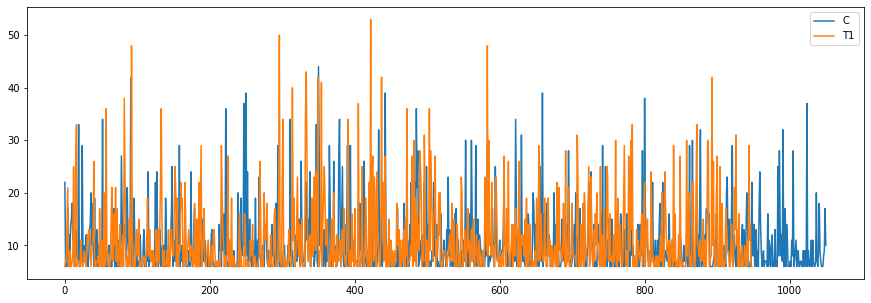

In [67]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

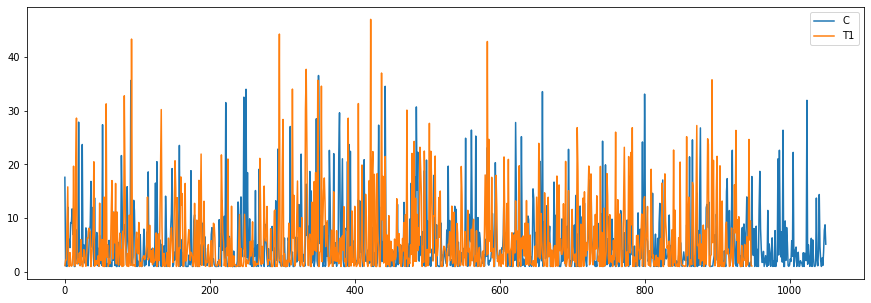

In [68]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [69]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [70]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [71]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [72]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,10.434669,22.324438,-1.455100,6.027589,6.656548,False
1,T1,sessions,-3.470638,-0.686002,-6.255275,1.131324,1.092060,True
3,T1,mean_tracks_per_session,7.254518,13.237622,1.271415,10.301041,11.048331,True
4,T1,mean_time_per_session,12.668193,23.973420,1.362966,5.338687,6.015002,True
2,T1,mean_request_latency,3.117109,5.316282,0.917937,0.620021,0.639347,True
